# WEEK 3 GRADED ASSIGNMENT: SEGMENTING AND CLUSTERING TORONTO NEIGHBORHOODS

In [1]:
# IMPORTING ALL REQUIRED LIBRARIES

import pandas as pd 
import numpy as np 
import random # library to generate random numbers
import requests
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # transform address into latitude and longitude values
from IPython.display import Image # library to display images
from IPython.core.display import HTML # library to display images
from IPython.display import display_html
from pandas.io.json import json_normalize # convert json file to dataframe
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # for plotting
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('ALL REQUIRED LIBRARIES IMPORTED.')

ALL REQUIRED LIBRARIES IMPORTED.


## STEPS
### 1. Scrape the Wikipedia page
### 2. Wrangle & clean the data
### 3. Read data it into a pandas dataframe similar to New York dataset

In [2]:
# Scrape Wikipage for Toronto Postal Codes
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)

#Process and convert html data to Dataframe
data = response.text
soup = BeautifulSoup(data,'html.parser')
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)

#Data Cleanup
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [3]:
df.shape

(103, 3)

# SECTION 2: Adding Longitude and Latitude Data

In [4]:
# get the data and create the dataframe
url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'
df_location=pd.read_csv(url)
df_location.head(10)
    

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [5]:
# Correct Header Name prior to merging table

df_location = df_location.rename(columns = {'Postal Code':'PostalCode'}) 
df_location.head(10)

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [6]:
# Merge the 2 tables using PostalCode column as reference
df_new = pd.merge(df, df_location, on = 'PostalCode')
df_new

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [7]:
print("2 new columns (location data) have been added to previous table using PostalCode column to link the tables")
print("New data table shape is: ", df_new.shape)

2 new columns (location data) have been added to previous table using PostalCode column to link the tables
New data table shape is:  (103, 5)


# SECTION 3: Filtering to get only Boroughs that contain the name: "Toronto" & Clustering

In [8]:
df_filter=df_new[df_new['Borough'].str.contains('Toronto')]
df_toronto=df_filter.reset_index(drop=True)
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [9]:
df_toronto['Borough'].value_counts()

Downtown Toronto    18
Central Toronto      9
East Toronto         6
West Toronto         6
Name: Borough, dtype: int64

In [10]:
df_toronto.shape

(39, 5)

Based on the following assumptions:  
"East TorontoBusiness reply mail Processing Centre969 Eastern" is part of East Toronto  
"East YorkEast Toronto" is part of East Toronto  
"Downtown TorontoStn A PO Boxes25 The Esplanade" is part of Downtown Toronto  

39 Postcodes contain "Toronto" in the Borough name  
4 Boroughs exist with Toronto in the name 
                                             

In [11]:

df_toronto['Class']=df_toronto['Borough'].replace(to_replace=['Downtown Toronto','Central Toronto','East Toronto','West Toronto'],value=[1,2,3,4],inplace=False)

df_toronto['Class'] = df_toronto.Class.astype(int)

df_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Class
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,3
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,1
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,4
9,M4J,East Toronto,The Danforth East,43.685347,-79.338106,3


# Creating a Folium Map to view the Neighborhoods

In [12]:

address = 'Toronto'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

kclusters=len(df_toronto.Class.unique())
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood'], df_toronto['Class']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

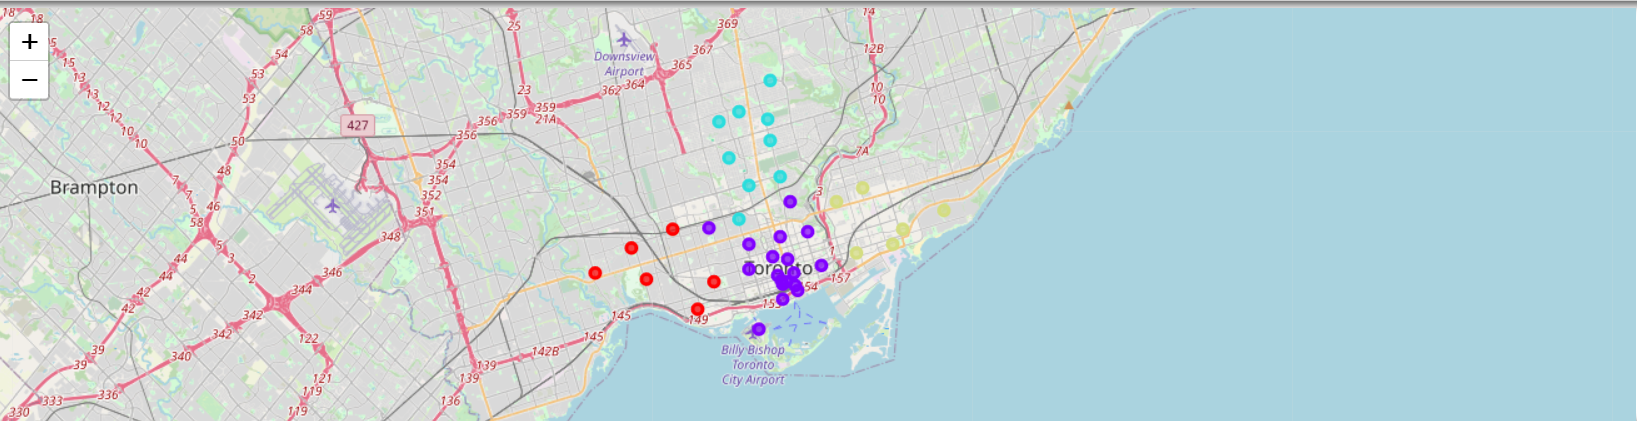

As shown in the map, there are 4 clusters of the Boroughs with Toronto in the name